## Caricamento del dataset

In [1]:
# monto drive in cui sono salvati migliori modelli da usare per l'inferenza
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DeepLearningResults/

Mounted at /content/drive
/content/drive/MyDrive/DeepLearningResults


In [2]:
import kagglehub
import os

# Scarica il dataset
path = kagglehub.dataset_download("rickyyyyyyy/torchvision-stanford-cars")

print("Path to dataset files:", path)
dataset_path = path

100%|██████████| 1.83G/1.83G [00:25<00:00, 76.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rickyyyyyyy/torchvision-stanford-cars/versions/2


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.model_selection import train_test_split


def get_transforms():
    return {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),

            transforms.RandomRotation(5),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.03),
            transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),
            transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
            transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.IMAGENET),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.3)),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),

            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        ]),
        'test_val': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }



def load_dataset(dataset_path, seed, augmented):
    data_transforms = get_transforms()

    if augmented:
      # load train ds
      trainset = torchvision.datasets.StanfordCars(root=dataset_path, split='train', download=False, transform=data_transforms['train'])
    else:
      # no aug
      trainset = torchvision.datasets.StanfordCars(root=dataset_path, split='train', download=False, transform=data_transforms['test_val'])

    class_names=trainset.classes

    # load test set
    full_test = torchvision.datasets.StanfordCars(root=dataset_path, split='test',
                                                download=False, transform=data_transforms['test_val'])

    labels = np.array([label for _, label in full_test._samples])

    # test set in 60% test e 40% validation mantenendo le proporzioni delle classi
    test_indices, val_indices = train_test_split(np.arange(len(labels)), test_size=0.4, stratify=labels, random_state=seed)

    testset = torch.utils.data.Subset(full_test, test_indices)
    valset = torch.utils.data.Subset(full_test, val_indices)

    print(f"Augmented: {augmented}")
    print(f"Train set size: {len(trainset)}, Validation set size: {len(valset)}, Test set size: {len(testset)}")

    return trainset, valset, testset, class_names



## Caricamento del modello

In [4]:
# Funzione per ottenere il modello selezionato.
def get_model(model_name, num_classes=196):

    if model_name == "resnet18":
        model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

        '''
        Congelo tutti i layers. Cong1234

        # define a function to freeze the model layers
        def set_parameter_requires_grad(model, req_grad = False):
            for param in model.parameters():
                param.requires_grad = req_grad
        set_parameter_requires_grad(model, req_grad=False)
        '''

        '''
        Congelo primo e secondo layers. Cong12
         # Funzione per congelare i layer
        def set_parameter_requires_grad(net, req_grad=False):
            for name, param in net.named_parameters():
                if "layer3" not in name and "layer4" not in name:
                    param.requires_grad = req_grad

        # Congela tutti i layer tranne layer3 e layer4
        set_parameter_requires_grad(model, req_grad=False)
        '''

        # Sblocca tutti i parametri per l'addestramento, NOcong
        for param in model.parameters():
            param.requires_grad = True

        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    else:
        raise ValueError(f"Model {model_name} is not supported.")

    return model

## Inferenza
Visualizzazione di alcune immagini con la relativa labels reale e quella predetta.

Augmented: True
Train set size: 8144, Validation set size: 3217, Test set size: 4824
Device:  cpu
Model loaded!


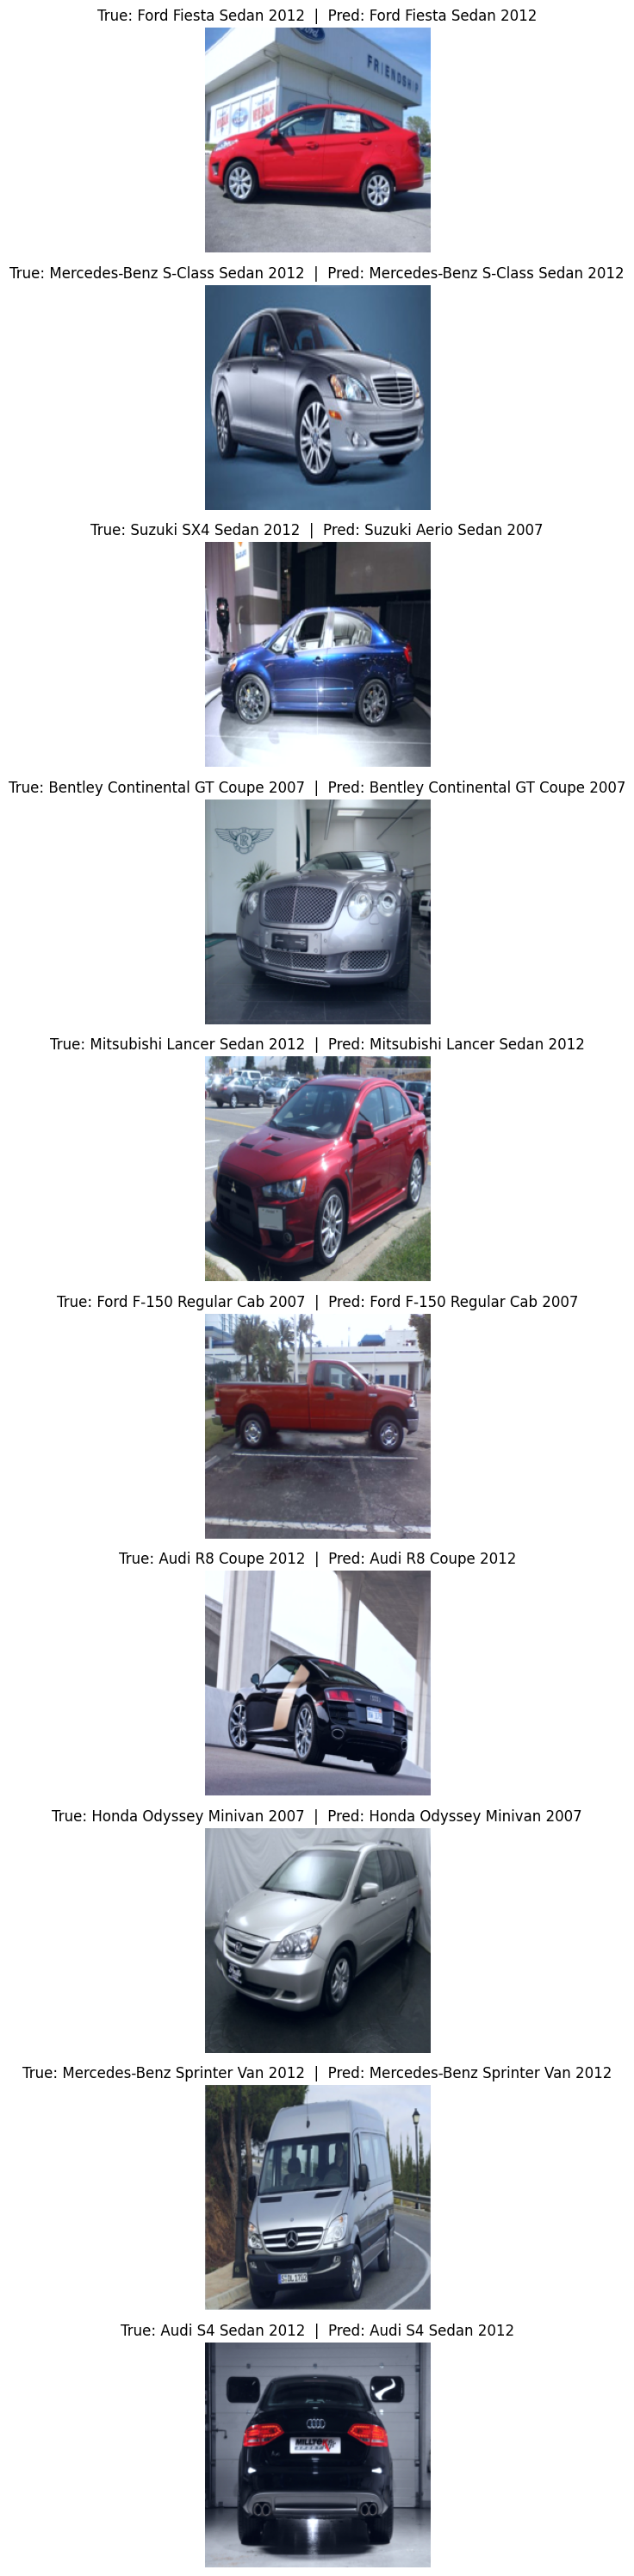

Predizione completata:
 - Classe vera: Ford Fiesta Sedan 2012
 - Classe predetta: Ford Fiesta Sedan 2012
Predizione completata:
 - Classe vera: Mercedes-Benz S-Class Sedan 2012
 - Classe predetta: Mercedes-Benz S-Class Sedan 2012
Predizione completata:
 - Classe vera: Suzuki SX4 Sedan 2012
 - Classe predetta: Suzuki Aerio Sedan 2007
Predizione completata:
 - Classe vera: Bentley Continental GT Coupe 2007
 - Classe predetta: Bentley Continental GT Coupe 2007
Predizione completata:
 - Classe vera: Mitsubishi Lancer Sedan 2012
 - Classe predetta: Mitsubishi Lancer Sedan 2012
Predizione completata:
 - Classe vera: Ford F-150 Regular Cab 2007
 - Classe predetta: Ford F-150 Regular Cab 2007
Predizione completata:
 - Classe vera: Audi R8 Coupe 2012
 - Classe predetta: Audi R8 Coupe 2012
Predizione completata:
 - Classe vera: Honda Odyssey Minivan 2007
 - Classe predetta: Honda Odyssey Minivan 2007
Predizione completata:
 - Classe vera: Mercedes-Benz Sprinter Van 2012
 - Classe predetta: Merce

In [10]:
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import os
import torch.nn as nn

import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id,seed):
        worker_seed = seed + worker_id
        np.random.seed(worker_seed)
        random.seed(worker_seed)


# Funzione per denormalizzare le immagini (usata per la visualizzazione)
def denorm(x):
    out = x * 0.229 + 0.485  # Denormalizza con i valori di mean e std di ImageNet
    return out.clamp(0, 1)


to_pil = transforms.ToPILImage()

def main():
    seed = 65
    set_seed(seed)
    # Generatore e worker seed
    g = torch.Generator()
    g.manual_seed(seed)

    _, _, testset, class_names = load_dataset(dataset_path,seed,True)

    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2, worker_init_fn=lambda worker_id: seed_worker(worker_id, seed), generator=g)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: ", device)

    model = get_model("resnet18", num_classes=196)
    model.load_state_dict(torch.load("./stanford_net_runA_r18_SGD_lr001_bs32_NOcong_seed42.pth", map_location=torch.device('cpu')))
    #model.load_state_dict(torch.load("./stanford_net_runEarly20_r18_adam_lr00001_bs32_NOcong_seed42.pth", map_location=torch.device('cpu')))

    print("Model loaded!")
    model.eval()

    dataiter = iter(testloader)
    images, labels = next(dataiter)  # Estrai il primo batch
    images, labels = images[:10], labels[:10]  # Prendi solo le prime 10 immagini

    # inferenza per ogni immagine
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    # visualizza le 10 immagini una sotto l'altra
    fig, axes = plt.subplots(10, 1, figsize=(10, 30))  # Una colonna, 10 righe
    for i in range(10):
        img = denorm(images[i])
        pil_img = to_pil(img)
        axes[i].imshow(pil_img)
        axes[i].set_title(f"True: {class_names[labels[i]]}  |  Pred: {class_names[preds[i]]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

    # Stampa il risultato dell'inferenza
    for i in range(10):
        print(f"Predizione completata:\n - Classe vera: {class_names[labels[i]]}\n - Classe predetta: {class_names[preds[i]]}")



if __name__ == "__main__":
    main()